## This notebook I wil reverse engineer the current partition method 

This is the partition explainer example data. It is relatively small so I will use this for development and figuring out if my approach works.

https://github.com/shap/shap/blob/master/notebooks/tabular_examples/model_agnostic/Simple%20California%20Demo.ipynb

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.cluster
from xgboost import XGBRegressor
import time

import shap
from numba import njit

from shap.utils import (
    MaskedModel,
    delta_minimization_order)

seed = 2023
np.random.seed(seed)

In [3]:
X, y = shap.datasets.california()
model = XGBRegressor(n_estimators=100, subsample=0.3)
model.fit(X, y)

instance = X[0:1]
references = X[1:100]

In [4]:
def partition_tree(X, metric="correlation"):
    X_full_rank = X + np.random.randn(*X.shape) * 1e-8
    D = scipy.spatial.distance.pdist(
        X_full_rank.fillna(X_full_rank.mean()).T, metric=metric
    )
    return scipy.cluster.hierarchy.complete(D)

In [5]:
X.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

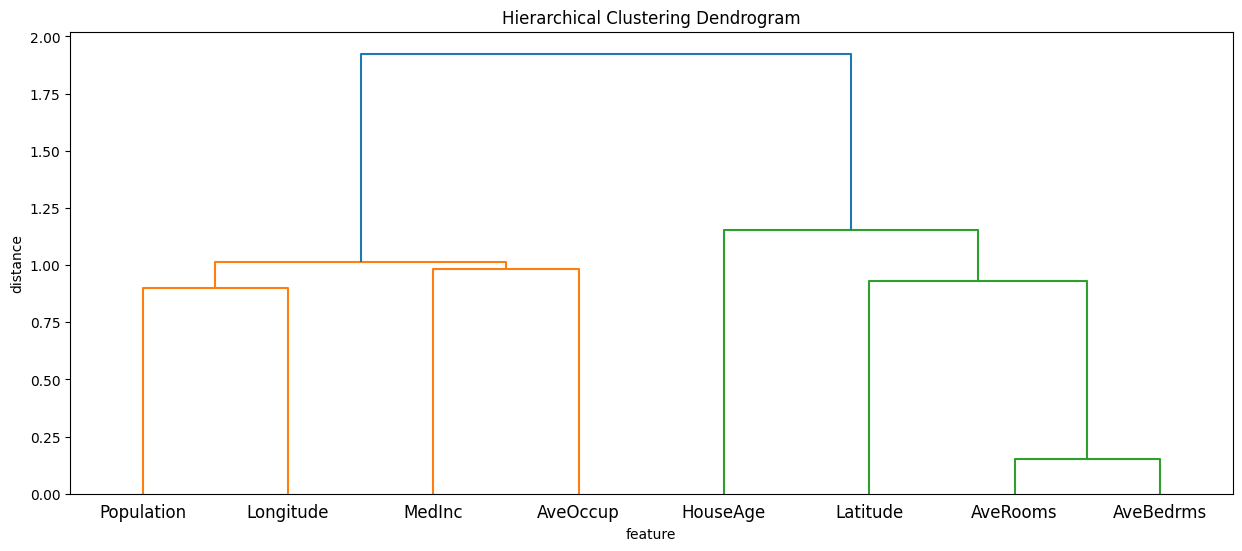

In [6]:
partition_tree = shap.utils.partition_tree(X)
plt.figure(figsize=(15, 6))
sp.cluster.hierarchy.dendrogram(partition_tree, labels=X.columns)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("feature")
plt.ylabel("distance")
plt.show()

In [7]:
# build a masker from partition tree, this masker object is what I am aiming to rewrite to respect any arbitrary hierarchy 
masker = shap.maskers.Partition(X, clustering=partition_tree)
# build explainer objects

exact_explainer = shap.ExactExplainer(model.predict, masker)
partition_explainer = shap.PartitionExplainer(model.predict, masker)

exact_start=time.time()
exact_shap_values = exact_explainer(instance)
print("exact method time: ", time.time()-exact_start)

partition_start=time.time()
partition_shap_values = partition_explainer(instance)
print("partition method time: ", time.time()-partition_start)


exact method time:  1.044276475906372
partition method time:  0.28691887855529785


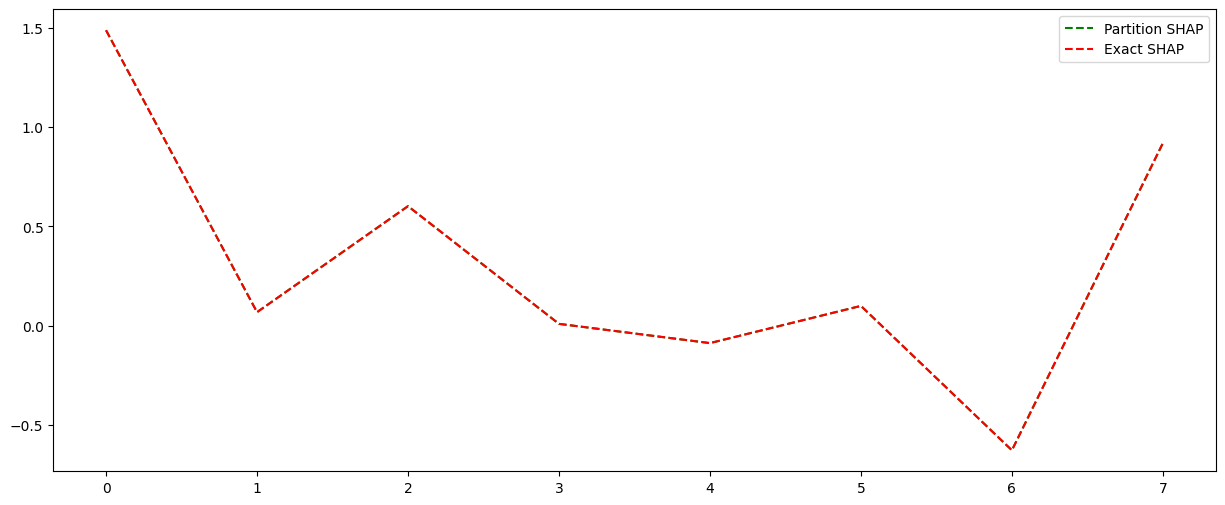

In [8]:
plt.figure(figsize=(15, 6))

plt.plot(exact_shap_values[0].values, "g--", label="Partition SHAP")
plt.plot(partition_shap_values[0].values, "r--", label="Exact SHAP")

plt.legend()
plt.show()

The Exact method produces with the same masker the same result in a shorter time than the partition method.

### Both methods call the make_masks function from shap.utils._masked_model.py
This function traverses the scipy tree object and returns masks for each individual feature and each coalition level of the hierarchy. This is a basic building block from which both PartitionExplainer and ExactExplainer then build up the entire list of masks. 

In [11]:
def make_masks(cluster_matrix):
    """Builds a sparse CSR mask matrix from the given clustering.

    This function is optimized since trees for images can be very large.
    """
    M = cluster_matrix.shape[0] + 1
    indices_row_pos = np.zeros(2 * M - 1, dtype=int)
    indptr = np.zeros(2 * M, dtype=int)
    indices = np.zeros(int(np.sum(cluster_matrix[:,3])) + M, dtype=int)

    # build an array of index lists in CSR format
    _init_masks(cluster_matrix, M, indices_row_pos, indptr)
    _rec_fill_masks(cluster_matrix, indices_row_pos, indptr, indices, M, cluster_matrix.shape[0] - 1 + M)
    mask_matrix = scipy.sparse.csr_matrix(
        (np.ones(len(indices), dtype=bool), indices, indptr),
        shape=(2 * M - 1, M)
    )

    return mask_matrix

@njit
def _init_masks(cluster_matrix, M, indices_row_pos, indptr):
    pos = 0
    for i in range(2 * M - 1):
        if i < M:
            pos += 1
        else:
            pos += int(cluster_matrix[i-M, 3])
        indptr[i+1] = pos
        indices_row_pos[i] = indptr[i]

@njit
def _rec_fill_masks(cluster_matrix, indices_row_pos, indptr, indices, M, ind):
    pos = indices_row_pos[ind]

    if ind < M:
        indices[pos] = ind
        return

    lind = int(cluster_matrix[ind-M,0])
    rind = int(cluster_matrix[ind-M,1])
    lind_size = int(cluster_matrix[lind-M, 3]) if lind >= M else 1
    rind_size = int(cluster_matrix[rind-M, 3]) if rind >= M else 1

    lpos = indices_row_pos[lind]
    rpos = indices_row_pos[rind]

    _rec_fill_masks(cluster_matrix, indices_row_pos, indptr, indices, M, lind)
    indices[pos:pos + lind_size] = indices[lpos:lpos + lind_size]

    _rec_fill_masks(cluster_matrix, indices_row_pos, indptr, indices, M, rind)
    indices[pos + lind_size:pos + lind_size + rind_size] = indices[rpos:rpos + rind_size]
    
    


In [12]:
make_masks(partition_tree).toarray()

array([[ True, False, False, False, False, False, False, False],
       [False,  True, False, False, False, False, False, False],
       [False, False,  True, False, False, False, False, False],
       [False, False, False,  True, False, False, False, False],
       [False, False, False, False,  True, False, False, False],
       [False, False, False, False, False,  True, False, False],
       [False, False, False, False, False, False,  True, False],
       [False, False, False, False, False, False, False,  True],
       [False, False,  True,  True, False, False, False, False],
       [False, False, False, False,  True, False, False,  True],
       [False, False,  True,  True, False, False,  True, False],
       [ True, False, False, False, False,  True, False, False],
       [ True, False, False, False,  True,  True, False,  True],
       [False,  True,  True,  True, False, False,  True, False],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

In [13]:
def partition_delta_indexes(partition_tree, all_masks):
    """Return an delta index encoded array of all the masks possible while following the given partition tree."""
    # convert the masks to delta index format
    mask = np.zeros(all_masks.shape[1], dtype=bool)
    delta_inds = []
    for i in range(len(all_masks)):
        inds = np.where(mask ^ all_masks[i, :])[0]
        print(inds)

        for j in inds[:-1]:
            delta_inds.append(
                -j - 1
            )  # negative + (-1) means we have more inds still to change...
        if len(inds) == 0:
            delta_inds.append(MaskedModel.delta_mask_noop_value)
        else:
            delta_inds.extend(inds[-1:])
        mask = all_masks[i, :]
        # print(delta_inds)

    return np.array(delta_inds)


def partition_masks(partition_tree):
    """Return an array of all the masks possible while following the given partition tree."""
    M = partition_tree.shape[0] + 1
    mask_matrix = make_masks(partition_tree)
    all_masks = []
    m00 = np.zeros(M, dtype=bool)
    all_masks.append(m00)
    all_masks.append(~m00)
    # inds_stack = [0,1]
    inds_lists = [[[], []] for i in range(M)]
    _partition_masks_recurse(
        len(partition_tree) - 1,
        m00,
        0,
        1,
        inds_lists,
        mask_matrix,
        partition_tree,
        M,
        all_masks,
    )

    all_masks = np.array(all_masks)
    
    # we resort the clustering matrix to minimize the sequential difference between the masks
    # this minimizes the number of model evaluations we need to run when the background sometimes
    # matches the foreground. We seem to average about 1.5 feature changes per mask with this
    # approach. This is not as clean as the grey code ordering, but a perfect 1 feature change
    # ordering is not possible with a clustering tree
    order = delta_minimization_order(all_masks)
    inverse_order = np.arange(len(order))[np.argsort(order)]

    for inds_list0, inds_list1 in inds_lists:
        for i in range(len(inds_list0)):
            inds_list0[i] = inverse_order[inds_list0[i]]
            inds_list1[i] = inverse_order[inds_list1[i]]

    # Care: inds_lists have different lengths, so partition_masks_inds is a "ragged" array. See GH #3063
    partition_masks = all_masks[order]
    partition_masks_inds = [[np.array(on), np.array(off)] for on, off in inds_lists]
    return partition_masks, partition_masks_inds


# TODO: this should be a jit function... which would require preallocating the inds_lists (sizes are 2**depth of that ind)
# TODO: we could also probable avoid making the masks at all and just record the deltas if we want...
def _partition_masks_recurse(
    index, m00, ind00, ind11, inds_lists, mask_matrix, partition_tree, M, all_masks
):
    if index < 0:
        inds_lists[index + M][0].append(ind00)
        inds_lists[index + M][1].append(ind11)
        return

    # get our children indexes
    left_index = int(partition_tree[index, 0] - M)
    right_index = int(partition_tree[index, 1] - M)

    # build more refined masks
    print(m00)
    m10 = (
        m00.copy()
    )  # we separate the copy from the add so as to not get converted to a matrix
    print("index on left",left_index+M)
    m10[:] += mask_matrix[left_index + M, :]
    print(m10)
    m01 = m00.copy()
    print("index on right",right_index+M)
    m01[:] += mask_matrix[right_index + M, :]
    print(m01)

    # record the new masks we made # simple counter

    ind01 = len(all_masks)
    #print("ind01",ind01)
    all_masks.append(m01)

    ind10 = len(all_masks)
    #print("ind10",ind10)
    all_masks.append(m10)

    # inds_stack.append(len(all_masks) - 2)
    # inds_stack.append(len(all_masks) - 1)

    # recurse left and right with both 1 (True) and 0 (False) contexts
    # print(left_index, m00, ind00, ind10, inds_lists, mask_matrix, partition_tree, M, all_masks)
    _partition_masks_recurse(
        left_index,
        m00,
        ind00,
        ind10,
        inds_lists,
        mask_matrix,
        partition_tree,
        M,
        all_masks,
    )
    _partition_masks_recurse(
        right_index,
        m10,
        ind10,
        ind11,
        inds_lists,
        mask_matrix,
        partition_tree,
        M,
        all_masks,
    )
    _partition_masks_recurse(
        left_index,
        m01,
        ind01,
        ind11,
        inds_lists,
        mask_matrix,
        partition_tree,
        M,
        all_masks,
    )
    _partition_masks_recurse(
        right_index,
        m00,
        ind00,
        ind01,
        inds_lists,
        mask_matrix,
        partition_tree,
        M,
        all_masks,
    )
    
# @njit
# def delta_minimization_order(all_masks, max_swap_size=100, num_passes=2):
#     order = np.arange(len(all_masks))
#     for _ in range(num_passes):
#         for length in list(range(2, max_swap_size)):
#             for i in range(1, len(order)-length):
#                 if _reverse_window_score_gain(all_masks, order, i, length) > 0:
#                     _reverse_window(order, i, length)
#     return order

In [14]:
_partition_masks, _partition_masks_inds = partition_masks(
    partition_tree
)
_partition_delta_indexes = partition_delta_indexes(
    partition_tree, _partition_masks
)

[False False False False False False False False]
index on left 12
[ True False False False  True  True False  True]
index on right 13
[False  True  True  True False False  True False]
[False False False False False False False False]
index on left 9
[False False False False  True False False  True]
index on right 11
[ True False False False False  True False False]
[False False False False False False False False]
index on left 4
[False False False False  True False False False]
index on right 7
[False False False False False False False  True]
[False False False False  True False False  True]
index on left 0
[ True False False False  True False False  True]
index on right 5
[False False False False  True  True False  True]
[ True False False False False  True False False]
index on left 4
[ True False False False  True  True False False]
index on right 7
[ True False False False False  True False  True]
[False False False False False False False False]
index on left 0
[ True False Fal

In [15]:
_partition_masks_inds

[[array([21, 23,  0, 16, 38, 10,  8, 43]),
  array([24, 25, 17, 18, 37, 11, 44, 41])],
 [array([25, 28,  0, 45]), array([14, 11,  2,  8])],
 [array([26, 27, 14, 35, 32, 33, 25, 34,  3,  5,  2,  6, 49, 48,  0, 47]),
  array([12, 11, 13, 36, 31, 28, 30, 29,  4,  8,  1,  7, 50, 45, 51, 46])],
 [array([12, 26, 13, 14, 31, 32, 30, 25,  4,  3,  1,  2, 50, 49, 51,  0]),
  array([11, 27, 36, 35, 28, 33, 29, 34,  8,  5,  7,  6, 45, 48, 46, 47])],
 [array([ 0, 20, 18, 19,  8, 39, 41, 40]),
  array([22, 21, 15, 25,  9, 38, 42, 11])],
 [array([24, 21, 17,  0, 37, 38, 44,  8]),
  array([25, 23, 18, 16, 11, 10, 41, 43])],
 [array([14, 36, 25, 29,  2,  7,  0, 46]),
  array([26, 11, 32, 28,  3,  8, 49, 45])],
 [array([22,  0, 15, 18,  9,  8, 42, 41]),
  array([21, 20, 25, 19, 38, 39, 11, 40])]]


I will first figure out how to create masks consistent with an arbitrary hierarchy. 

Essentially we want to specify such hierarchy *but the tree is non-binary*

I will use dictionaries and a class to store values

In [17]:
##Here I got a couple different definitions. 
##I recon the dictionary definition may be faster as I will use a custum class anyhow.



#hierarchy = [['AveRooms', 'AveBedrms', 'AveOccup', 'HouseAge'],[['Latitude', 'Longitude'],['MedInc', 'Population']]]
# hierarchy = {
#         "HouseCharacteristics": 
#            ["AveRooms", "AveBedrms", "AveOccup", "HouseAge"],
#         "Area": {
#             "Location": ["Latitude", "Longitude"],
#             "Neighbours": ["MedInc", "Population"]
#           },
   
# }

# hierarchy = {
#     "Top":{
#     "HouseCharacteristics": ["AveRooms", "AveBedrms", "AveOccup", "HouseAge"],
#     "Area": {
#         "Location": ["Latitude", "Longitude"],
#         "Neighbours": {"MedInc":["MedInc"], "Population":["Population"]
#         }
#         }
#     }
# }



hierarchy = {
    "Top":{
    "HouseCharacteristics": ["AveRooms", "AveBedrms", "AveOccup", "HouseAge"],
    "Area": {
        "Location": ["Latitude", "Longitude"],
        "Neighbours": ["MedInc", "Population"]
        }
    }
}


columns = X.columns # just the index for reference 

In [18]:
## gonna put the data into a class with its own methods
class NonBinTree:
    def __init__(self, val, is_feature=False):
        self.val = val
        self.nodes = []
        self.is_feature = is_feature

    def add_node(self, val, is_feature=False):
        self.nodes.append(NonBinTree(val, is_feature))

    def __repr__(self):
        return f"({self.val}, {self.is_feature}): {self.nodes}"

    #function to translate the dictionary to class, 
def build_tree_from_dict(data, tree):
    if isinstance(data, dict):
        for key, value in data.items():
            new_node = NonBinTree(key)
            tree.nodes.append(new_node)
            build_tree_from_dict(value, new_node)
    elif isinstance(data, list):
        for item in data:
            tree.add_node(item, is_feature=True)

# def find_node(tree, target):
#     if tree.val == target:
#         return tree
#     for node in tree.nodes:
#         result = find_node(node, target)
#         if result:
#             return result
#     return None

def get_all_leaf_values(node):
    values = []
    if node:
        for child in node.nodes:
            if child.is_feature:
                values.append(child.val)
            else:
                values.extend(get_all_leaf_values(child))
    return values



def create_masks(node, columns):
    masks = []

    for i, subset in enumerate(node.nodes):
        if subset.is_feature:
            #mask = columns.isin([subset.val])
            mask = columns == subset.val
            #print(i)
            masks.append(mask)
        else:

            mask = columns.isin(get_all_leaf_values(subset))
            masks.append(mask)
            masks.extend(create_masks(subset,columns))
    

    return masks



In [19]:
root = NonBinTree("Root")

build_tree_from_dict(hierarchy, root)

# Create masks for the given hierarchy
masks = create_masks(root,columns)

mask_matrix = scipy.sparse.csr_matrix(masks)
mask_matrix.toarray()

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True, False,  True, False, False],
       [False, False,  True, False, False, False, False, False],
       [False, False, False,  True, False, False, False, False],
       [False, False, False, False, False,  True, False, False],
       [False,  True, False, False, False, False, False, False],
       [ True, False, False, False,  True, False,  True,  True],
       [False, False, False, False, False, False,  True,  True],
       [False, False, False, False, False, False,  True, False],
       [False, False, False, False, False, False, False,  True],
       [ True, False, False, False,  True, False, False, False],
       [ True, False, False, False, False, False, False, False],
       [False, False, False, False,  True, False, False, False]])

cool so now that we have the building blocks of all possible coalitions consistent with the levels strucutre. 

In [21]:
def create_masks(node, columns):
    masks = []

    for i, subset in enumerate(node.nodes):
        if subset.is_feature:
            #mask = columns.isin([subset.val])
            mask = columns == subset.val
            #print(i)
            masks.append(mask)
        else:

            mask = columns.isin(get_all_leaf_values(subset))
            masks.append(mask)
            masks.extend(create_masks(subset,columns))
    

    return masks

In [22]:
import numpy as np
import scipy.sparse

class NonBinTree:
    def __init__(self, val, is_feature=False):
        self.val = val
        self.nodes = []
        self.is_feature = is_feature

    def add_node(self, val, is_feature=False):
        self.nodes.append(NonBinTree(val, is_feature))

    def __repr__(self):
        return f"({self.val}, {self.is_feature}): {self.nodes}"

def build_tree_from_dict(data, tree):
    if isinstance(data, dict):
        for key, value in data.items():
            new_node = NonBinTree(key)
            tree.nodes.append(new_node)
            build_tree_from_dict(value, new_node)
    elif isinstance(data, list):
        for item in data:
            tree.add_node(item, is_feature=True)

def get_all_leaf_values(node):
    values = []
    if node:
        for child in node.nodes:
            if child.is_feature:
                values.append(child.val)
            else:
                values.extend(get_all_leaf_values(child))
    return values

def create_all_masks(node, columns):
    masks = []

    if node.is_feature:
        mask = columns == node.val
        masks.append(mask)
    else:
        # Create mask for current node
        current_node_mask = columns.isin(get_all_leaf_values(node))
        masks.append(current_node_mask)
        
        # Recursively create masks for all child nodes
        for subset in node.nodes:
            child_masks = create_all_masks(subset, columns)
            masks.extend(child_masks)

    return masks

# Hierarchy definition
hierarchy = {
    "Top": {
        "HouseCharacteristics": ["AveRooms", "AveBedrms", "AveOccup", "HouseAge"],
        "Area": {
            "Location": ["Latitude", "Longitude"],
            "Neighbours": ["MedInc", "Population"]
        }
    }
}

# Columns definition
columns = X.columns

# Building the tree
root = NonBinTree("Root")
build_tree_from_dict(hierarchy, root)

# Create all possible masks consistent with the structure
all_masks = create_all_masks(root, columns)

# Convert to sparse matrix for efficiency
mask_matrix = scipy.sparse.csr_matrix(all_masks)
mask_matrix_array = mask_matrix.toarray()

# Print the resulting masks
print(mask_matrix_array)


[[ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [False  True  True  True False  True False False]
 [False False  True False False False False False]
 [False False False  True False False False False]
 [False False False False False  True False False]
 [False  True False False False False False False]
 [ True False False False  True False  True  True]
 [False False False False False False  True  True]
 [False False False False False False  True False]
 [False False False False False False False  True]
 [ True False False False  True False False False]
 [ True False False False False False False False]
 [False False False False  True False False False]]


In [ ]:
def _hierarchical_partition_masks_recurse(node, current_mask, ind00, ind11, inds_lists, mask_matrix, all_masks, columns):
    if node.is_feature:
        return
    
    node_index = columns.tolist().index(node.val) if node.val in columns else -1
    
    for child in node.nodes:
        new_mask = current_mask.copy()
        if child.is_feature:
            child_mask = columns == child.val
        else:
            child_mask = columns.isin(get_all_leaf_values(child))
        
        new_mask = new_mask | child_mask
        
        ind_new = len(all_masks)
        all_masks.append(new_mask)
        
        if node_index != -1:
            inds_lists[node_index][0].append(ind00)
            inds_lists[node_index][1].append(ind_new)
        
        _hierarchical_partition_masks_recurse(child, new_mask, ind_new, ind11, inds_lists, mask_matrix, all_masks, columns)

def hierarchical_partition_masks(node, columns):
    masks = create_masks(node, columns)
    mask_matrix = scipy.sparse.csr_matrix(masks)  # base components of the masks 
    all_masks = []
    m00 = np.zeros(columns.shape[0], dtype=bool)
    all_masks.append(m00)  # include all off 
    all_masks.append(~m00)  # include all on
    inds_lists = [[[], []] for _ in range(len(columns))]  # keep the on and off indexes for the features
    
    _hierarchical_partition_masks_recurse(node, m00, 0, 1, inds_lists, mask_matrix, all_masks, columns)
    
    all_masks = np.array(all_masks)
    
    partition_masks = all_masks  # for now disregard ordering  
    partition_masks_inds = [[np.array(on), np.array(off)] for on, off in inds_lists]
    return partition_masks, partition_masks_inds

# Generate partition masks
partition_masks, partition_masks_inds = hierarchical_partition_masks(root, columns)

print("Partition Masks:\n", partition_masks)
print("Partition Masks Indices:\n", partition_masks_inds)

In [ ]:
def hierarchical_partition_masks(node, columns):
    masks = create_masks(node, columns)
    mask_matrix = scipy.sparse.csr_matrix(masks) # base components of the masks 
    all_masks = []
    m00 = np.zeros(columns.shape[0], dtype=bool)
    all_masks.append(m00) # include all off 
    all_masks.append(~m00) # include all on
    inds_lists = [[[], []] for _ in range(len(columns))] # keep the on and off indexes for the features
    
    _hierarchical_partition_masks_recurse(node, m00, 0, 1, inds_lists, mask_matrix, all_masks, columns)
    
    all_masks = np.array(all_masks)
#     order = delta_minimization_order(all_masks)
#     inverse_order = np.arange(len( order))[np.argsort(order)]
    
#     for inds_list0, inds_list1 in inds_lists:
#         for i in range(len(inds_list0)):
#             inds_list0[i] = inverse_order[inds_list0[i]]
#             inds_list1[i] = inverse_order[inds_list1[i]]
    
    partition_masks = all_masks #[order] # for now disregard ordering  
    partition_masks_inds = [[np.array(on), np.array(off)] for on, off in inds_lists]
    return partition_masks, partition_masks_inds

def _hierarchical_partition_masks_recurse(node, m00, ind00, ind11, inds_lists, mask_matrix, all_masks, columns):
    if node.is_feature:
        node_index = np.where(columns == node.val)[0][0]
        inds_lists[node_index][0].append(ind00)
        inds_lists[node_index][1].append(ind11)
        return
    
    for subset in node.nodes:
        m10 = m00.copy()
        m10 |= columns.isin(get_all_leaf_values(subset))
        ind10 = len(all_masks)
        all_masks.append(m10)
        
        m01 = m00.copy()
        m01 |= columns.isin(get_all_leaf_values(subset))
        ind01 = len(all_masks)
        all_masks.append(m01)
        
        _hierarchical_partition_masks_recurse(subset, m00, ind00, ind10, inds_lists, mask_matrix, all_masks, columns)
        _hierarchical_partition_masks_recurse(subset, m10, ind10, ind11, inds_lists, mask_matrix, all_masks, columns)
        _hierarchical_partition_masks_recurse(subset, m01, ind01, ind11, inds_lists, mask_matrix, all_masks, columns)

# Using the hierarchy to create partition masks
partition_masks, partition_masks_inds = hierarchical_partition_masks(root, columns)

# Printing the result
print(partition_masks)
print(partition_masks_inds)


In [ ]:
for masks in partition_masks:
    print(masks)

In [ ]:
len(partition_masks)

In [ ]:
def hierarchical_partition_masks(node, columns):
    masks = create_masks(node, columns)
    mask_matrix = scipy.sparse.csr_matrix(masks)
    all_masks = []
    m00 = np.zeros(columns.shape, dtype=bool)
    all_masks.append(m00)
    all_masks.append(~m00)
    inds_lists = [[[], []] for _ in range(len(columns))]
    
    _hierarchical_partition_masks_recurse(node, m00, 0, 1, inds_lists, mask_matrix, all_masks, columns)
    
    all_masks = np.array(all_masks)
    order = np.arange(len(all_masks))  # Placeholder for delta_minimization_order
    inverse_order = np.arange(len(order))[np.argsort(order)]
    
    for inds_list0, inds_list1 in inds_lists:
        for i in range(len(inds_list0)):
            inds_list0[i] = inverse_order[inds_list0[i]]
            inds_list1[i] = inverse_order[inds_list1[i]]
    
    partition_masks = all_masks[order]
    partition_masks_inds = [[np.array(on), np.array(off)] for on, off in inds_lists]
    return partition_masks, partition_masks_inds

def _hierarchical_partition_masks_recurse(node, m00, ind00, ind11, inds_lists, mask_matrix, all_masks, columns):
    if node.is_feature:
        column_index = np.where(columns == node.val)[0][0]
        inds_lists[column_index][0].append(ind00)
        inds_lists[column_index][1].append(ind11)
        return
    
    for subset in node.nodes:
        m10 = m00.copy()
        m10 |= columns.isin(get_all_leaf_values(subset))
        ind10 = len(all_masks)
        all_masks.append(m10)
        
        m01 = m00.copy()
        m01 |= columns.isin(get_all_leaf_values(subset))
        ind01 = len(all_masks)
        all_masks.append(m01)
        
        _hierarchical_partition_masks_recurse(subset, m00, ind00, ind10, inds_lists, mask_matrix, all_masks, columns)
        _hierarchical_partition_masks_recurse(subset, m10, ind10, ind11, inds_lists, mask_matrix, all_masks, columns)
        _hierarchical_partition_masks_recurse(subset, m01, ind01, ind11, inds_lists, mask_matrix, all_masks, columns)

# Using the hierarchy to create partition masks
partition_masks, partition_masks_inds = hierarchical_partition_masks(root, columns)

# Printing the result
print(partition_masks)
print(partition_masks_inds)


In [ ]:
len(partition_masks)

## This is what the partition tree explainer uses scipy hierarchical clustering

# Reworking the make_masks function here